<a href="https://colab.research.google.com/github/athens-igg/dfu-models/blob/main/simpleCNN%2BPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 730.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 143.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()   # select kaggle.json


Saving kaggle (22).json to kaggle (22).json


{'kaggle (22).json': b'{"username":"athenkaggle","key":"bf20cbc4b76939b3bebcb528303e253c"}'}

In [3]:

!mkdir -p ~/.kaggle
!cp "kaggle (22).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [4]:

!kaggle datasets download -d purushomohan/dfu-wagners-classification

Dataset URL: https://www.kaggle.com/datasets/purushomohan/dfu-wagners-classification
License(s): unknown
  0% 0.00/44.6M [00:00<?, ?B/s]
100% 44.6M/44.6M [00:00<00:00, 2.27GB/s]


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [6]:
!unzip -q dfu-wagners-classification.zip -d /content/drive

In [7]:
input_train_data="/content/drive/Dataset/Training"
pso_train_data="/content/drive/pso_Dataset/PSO_Training"

input_valid_data="/content/drive/Dataset/Validation"
pso_valid_data="/content/drive/pso_Dataset/PSO_Validation"

In [8]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 27.8 MB/s eta 0:00:00


In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def qpso_segmentation(image, max_iter=30, swarm_size=15):
    # --- QPSO Implementation (Otsu-based fitness) ---
    def fitness(image, threshold):
        # Otsu’s between-class variance
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    particles = np.random.randint(1,255,(swarm_size,))
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]

    for _ in range(max_iter):
        mbest = np.mean(pbest)
        for i in range(swarm_size):
            phi = np.random.rand()
            p = phi*pbest[i] + (1-phi)*gbest
            u = np.random.rand()
            beta = 1.0
            new_particle = p + beta*np.sign(u-0.5)*np.abs(mbest - particles[i])*np.log(1.0/u)
            new_particle = int(np.clip(new_particle, 1, 254))

            f = fitness(image, new_particle)
            if f > pbest_fitness[i]:
                pbest[i] = new_particle
                pbest_fitness[i] = f
                if f > max(pbest_fitness):
                    gbest = new_particle
        particles = pbest.copy()

    return gbest






In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def pso_segmentation(image, max_iter=30, swarm_size=15, w=0.7, c1=1.5, c2=1.5):
    # --- Fitness: Otsu’s between-class variance ---
    def fitness(image, threshold):
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    # --- Initialize particles ---
    particles = np.random.randint(1,255,(swarm_size,))
    velocities = np.zeros(swarm_size)
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]
    gbest_fit = np.max(pbest_fitness)

    for _ in range(max_iter):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()

            # --- Velocity update ---
            velocities[i] = (
                w*velocities[i]
                + c1*r1*(pbest[i] - particles[i])
                + c2*r2*(gbest - particles[i])
            )

            # --- Position update ---
            particles[i] = int(np.clip(particles[i] + velocities[i], 1, 254))

            # --- Evaluate fitness ---
            f = fitness(image, particles[i])
            if f > pbest_fitness[i]:
                pbest[i] = particles[i]
                pbest_fitness[i] = f
                if f > gbest_fit:
                    gbest = particles[i]
                    gbest_fit = f

    return gbest


In [11]:
def process_training_dataset(input_train_data, pso_train_data):
    for cls in os.listdir(input_train_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path = os.path.join(input_train_data, cls)
        output_path = os.path.join(pso_train_data, cls)
        os.makedirs(output_path, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            img_path = os.path.join(input_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            best_thresh = pso_segmentation(img)
            _, segmented = cv2.threshold(img, best_thresh, 255, cv2.THRESH_BINARY)


            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path = os.path.join(output_path, img_name)
            cv2.imwrite(save_path, segmented_rgb)

        print(f"✅ Finished PSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path}")



In [12]:
# Example usage
input_train_data="/content/drive/Dataset/Training"
pso_train_data="/content/drive/pso_Dataset/PSO_Training"
process_training_dataset(input_train_data, pso_train_data)

Processing Grade 1 ...


100%|██████████| 141/141 [00:04<00:00, 30.85it/s]


✅ Finished PSO Segmentation for Grade 1.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 1
Processing Grade 0 ...


100%|██████████| 53/53 [00:01<00:00, 30.47it/s]


✅ Finished PSO Segmentation for Grade 0.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 557/557 [00:18<00:00, 29.61it/s]


✅ Finished PSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/pso_Dataset/PSO_Training/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 152/152 [00:05<00:00, 30.31it/s]


✅ Finished PSO Segmentation for Grade 2.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 2
Processing Grade 3 ...


100%|██████████| 62/62 [00:02<00:00, 30.99it/s]

✅ Finished PSO Segmentation for Grade 3.
   Saved in: /content/drive/pso_Dataset/PSO_Training/Grade 3


In [13]:

import os
import cv2
import numpy as np
from tqdm import tqdm

def pso_segmentation(image, max_iter=30, swarm_size=15, w=0.7, c1=1.5, c2=1.5):
    # --- Fitness: Otsu’s between-class variance ---
    def fitness(image, threshold):
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    # --- Initialize particles ---
    particles = np.random.randint(1,255,(swarm_size,))
    velocities = np.zeros(swarm_size)
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]
    gbest_fit = np.max(pbest_fitness)

    for _ in range(max_iter):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()

            # --- Velocity update ---
            velocities[i] = (
                w*velocities[i]
                + c1*r1*(pbest[i] - particles[i])
                + c2*r2*(gbest - particles[i])
            )

            # --- Position update ---
            particles[i] = int(np.clip(particles[i] + velocities[i], 1, 254))

            # --- Evaluate fitness ---
            f = fitness(image, particles[i])
            if f > pbest_fitness[i]:
                pbest[i] = particles[i]
                pbest_fitness[i] = f
                if f > gbest_fit:
                    gbest = particles[i]
                    gbest_fit = f

    return gbest

In [14]:
def process_validation_dataset(input_valid_data,pso_valid_data):
    for cls in os.listdir(input_valid_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path2 = os.path.join(input_valid_data, cls)
        output_path2 = os.path.join(pso_valid_data, cls)
        os.makedirs(output_path2, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path2)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            img_path2 = os.path.join(input_path2, img_name)
            img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            if img2 is None:
                continue

            best_thresh = pso_segmentation(img2)
            _, segmented = cv2.threshold(img2, best_thresh, 255, cv2.THRESH_BINARY)

            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb2 = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path2 = os.path.join(output_path2, img_name)
            cv2.imwrite(save_path2, segmented_rgb2)

        print(f"✅ Finished PSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path2}")

In [15]:
# Example usage

process_validation_dataset(input_valid_data, pso_valid_data)


Processing Grade 1 ...


100%|██████████| 16/16 [00:00<00:00, 30.73it/s]


✅ Finished PSO Segmentation for Grade 1.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 1
Processing Grade 0 ...


100%|██████████| 12/12 [00:00<00:00, 30.86it/s]


✅ Finished PSO Segmentation for Grade 0.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 49/49 [00:02<00:00, 23.18it/s]


✅ Finished PSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 19/19 [00:00<00:00, 30.72it/s]


✅ Finished PSO Segmentation for Grade 2.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 2
Processing Grade 3 ...


100%|██████████| 20/20 [00:00<00:00, 30.57it/s]

✅ Finished PSO Segmentation for Grade 3.
   Saved in: /content/drive/pso_Dataset/PSO_Validation/Grade 3


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
N_CLASSES = 5   # Wagner 0–4

# ============================
# 1) Data Preprocessing & Augmentation
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    pso_train_data,  # path to training dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    pso_valid_data,  # path to validation dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# ============================
# 2) Define Simple CNN Model
# ============================
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(N_CLASSES, activation="softmax")
])

# ============================
# 3) Compile
# ============================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# 4) Callbacks
# ============================
checkpoint = ModelCheckpoint(
    "/content/drive/Dataset/best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1),
    checkpoint
]

# ============================
# 5) Train
# ============================
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)


Found 965 images belonging to 5 classes.
Found 116 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4615 - loss: 1.8646

31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4635 - loss: 1.8526 - val_accuracy: 0.4138 - val_loss: 1.5083 - learning_rate: 0.0010
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6036 - loss: 1.1399 - val_accuracy: 0.4310 - val_loss: 1.5158 - learning_rate: 0.0010
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5802 - loss: 1.1693 - val_accuracy: 0.4224 - val_loss: 1.8875 - learning_rate: 0.0010
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5752 - loss: 1.1560

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5760 - loss: 1.1545 - val_accuracy: 0.4397 - val_loss: 1.4704 - learning_rate: 0.0010
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6104 - loss: 1.0907

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6109 - loss: 1.0899 - val_accuracy: 0.5086 - val_loss: 1.4198 - learning_rate: 0.0010
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6094 - loss: 1.0421 - val_accuracy: 0.4914 - val_loss: 1.6198 - learning_rate: 0.0010
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6372 - loss: 1.0667 - val_accuracy: 0.5172 - val_loss: 1.4522 - learning_rate: 0.0010
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6541 - loss: 0.9324

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6539 - loss: 0.9345 - val_accuracy: 0.4828 - val_loss: 1.2920 - learning_rate: 0.0010
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6497 - loss: 1.0101

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6498 - loss: 1.0087 - val_accuracy: 0.5259 - val_loss: 1.2057 - learning_rate: 0.0010
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6796 - loss: 0.8997 - val_accuracy: 0.5000 - val_loss: 1.3638 - learning_rate: 0.0010
Epoch 11/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6713 - loss: 0.9356 - val_accuracy: 0.5086 - val_loss: 1.2058 - learning_rate: 0.0010
Epoch 12/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6607 - loss: 0.9075 - val_accuracy: 0.5431 - val_loss: 1.3223 - learning_rate: 0.0010
Epoch 13/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6954 - loss: 0.8590

31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6951 - loss: 0.8596 - val_accuracy: 0.5345 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 14/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6933 - loss: 0.8812

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6930 - loss: 0.8812 - val_accuracy: 0.5431 - val_loss: 1.1061 - learning_rate: 0.0010
Epoch 15/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6959 - loss: 0.7924

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6962 - loss: 0.7928 - val_accuracy: 0.5776 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 16/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6969 - loss: 0.8202

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6968 - loss: 0.8206 - val_accuracy: 0.5690 - val_loss: 1.0330 - learning_rate: 0.0010
Epoch 17/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6889 - loss: 0.7804 - val_accuracy: 0.5690 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 18/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7039 - loss: 0.8028 - val_accuracy: 0.5431 - val_loss: 1.2657 - learning_rate: 0.0010
Epoch 19/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7170 - loss: 0.8117 - val_accuracy: 0.5345 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 20/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7092 - loss: 0.8047

31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7090 - loss: 0.8048 - val_accuracy: 0.6121 - val_loss: 1.0049 - learning_rate: 0.0010
Epoch 21/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6985 - loss: 0.7608 - val_accuracy: 0.5776 - val_loss: 1.0077 - learning_rate: 0.0010
Epoch 22/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7334 - loss: 0.7553 - val_accuracy: 0.5690 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 23/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7128 - loss: 0.7362

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7129 - loss: 0.7370 - val_accuracy: 0.6034 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 24/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6873 - loss: 0.7946

31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6878 - loss: 0.7941 - val_accuracy: 0.6293 - val_loss: 0.9149 - learning_rate: 0.0010
Epoch 25/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7141 - loss: 0.7811 - val_accuracy: 0.5776 - val_loss: 0.9668 - learning_rate: 0.0010


In [18]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_model = load_model("/content/drive/Dataset/best_model.h5")

# Evaluate on validation data
val_loss, val_acc = best_model.evaluate(val_gen)
print(f"Best Validation Accuracy: {val_acc*100:.2f}%")
print(f"Best Validation Loss: {val_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.6465 - loss: 0.8705
Best Validation Accuracy: 62.93%
Best Validation Loss: 0.9149


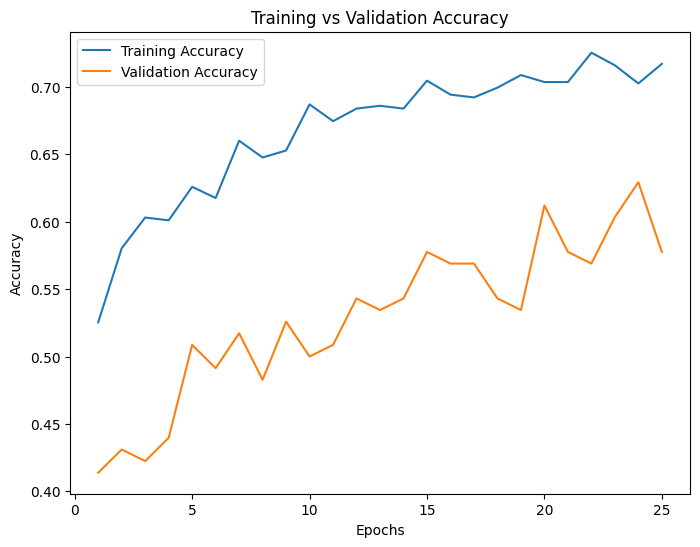

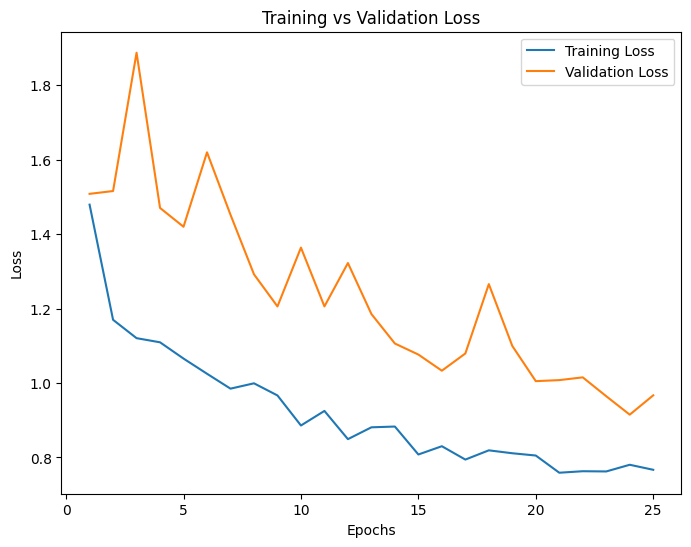

In [19]:
import matplotlib.pyplot as plt

# Use only the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [20]:
model.save('/content/drive/Dataset/best_model.h5')


Saving Screenshot 2025-09-21 233831.png to Screenshot 2025-09-21 233831.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


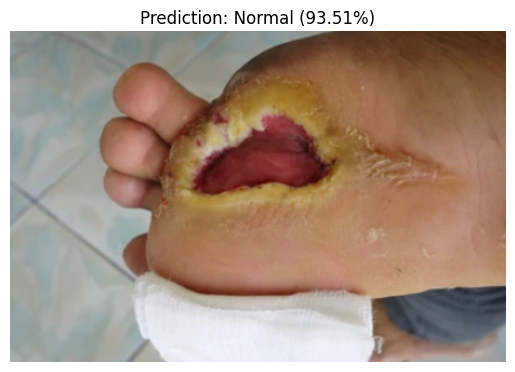

In [21]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade1", "Grade2", "Grade3", "Normal" ]
filename = list(uploaded.keys())[0]

# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = best_model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

In [23]:
model.save('best_model.h5')

from google.colab import files
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>